In [1]:
!date

Sat Feb 22 14:38:27 PST 2020


# Merfish

In [66]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=15

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [13]:
clusters = pd.read_csv("../merfish/cell_labels.csv")
clusters.index = clusters["Unnamed: 0"].values
del clusters["Unnamed: 0"]

In [6]:
adata = anndata.read_h5ad("../merfish/merfish_M1.h5ad")
tmp = pd.DataFrame({col: adata.obs.index.map(clusters[col]) for col in clusters})
adata.obs = tmp

In [20]:
adata.obs

,label,subclass,sampleID,sliceID,label_v1,AP_distance (um),pos_x (um),pos_y (um)
0,Sst_1,Sst,dataset2_sample6,dataset2_slice109,I30,1180,-79.474594,2211.467867
1,Endo,Endothelial,dataset1_sample1,dataset1_slice50,Endo,490,3837.284502,-3847.753461
2,L6_IT_1,L6_IT,dataset2_sample3,dataset2_slice139,E8,1480,3502.243851,-3511.940334
3,L2/3_IT_3,L2/3_IT,dataset2_sample1,dataset2_slice61,E2,700,-3975.718063,-2609.660891
4,VLMC,VLMC,dataset1_sample5,dataset1_slice260,VLMC,2590,-6370.114257,623.408623
...,...,...,...,...,...,...,...,...
243794,L5_IT_3,L5_IT,dataset2_sample3,dataset2_slice319,E13,3280,-6732.826681,1631.711188
243795,L2/3_IT_1,L2/3_IT,dataset1_sample4,dataset1_slice162,E5,1610,-6738.905580,-1201.478276
243796,L6_CT_2,L6_CT,dataset2_sample6,dataset2_slice289,E23,2980,-612.707832,-1602.161256
243797,Endo,Endothelial,dataset1_sample4,dataset1_slice170,Endo,1690,-93.964710,-5245.891323


In [49]:
sliceID = adata.obs.sliceID.unique()

In [44]:
gb = adata.obs.groupby("sliceID")["pos_x (um)", "pos_y (um)"]

In [90]:
adata.shape

(243799, 254)

In [91]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)

In [98]:
c = t2g.groupby("gene_name")["transcript_id"].nunique()

In [100]:
adata.var["n_iso"] = adata.var.index.map(c)

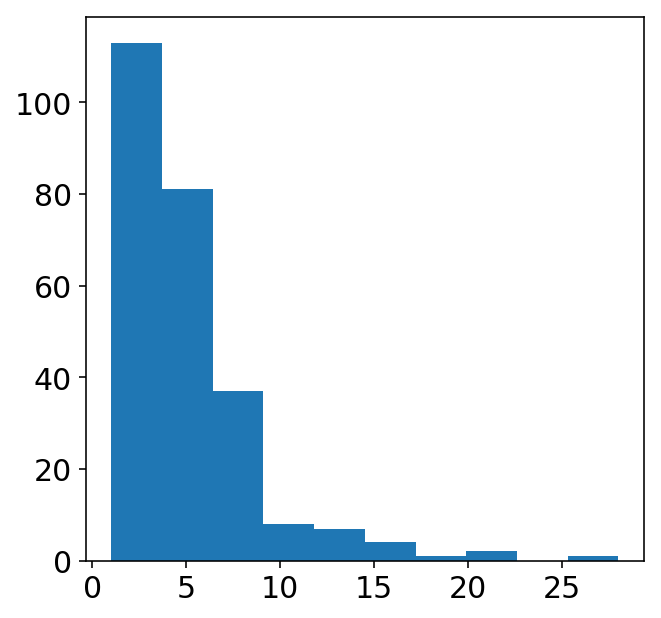

In [102]:
fig, ax = plt.subplots(figsize=(5,5))
x = adata.var["n_iso"].values
ax.hist(x)

plt.show()

In [107]:
top = np.array(['1500011B03Rik', '1700020I14Rik', '2610002M06Rik', '3110039M20Rik',
       '4632415L05Rik', '4921504A21Rik', '4930522L14Rik', '9430037G07Rik',
       'Abcg1', 'Abhd2', 'Acbd3', 'Adamts2', 'Adcy1', 'Agtrap', 'Alkbh5',
       'Ap4s1', 'Aph1c', 'Arhgdia', 'Arl5c', 'Arl8b', 'Asic2', 'Atp6v0e',
       'Banf1', 'Basp1', 'Bcdin3d', 'Bin1', 'Bmp2k', 'Bmt2', 'Bri3bp',
       'Btbd9', 'C130073E24Rik', 'C530043A13Rik', 'Casz1', 'Ccdc138',
       'Ccdc22', 'Ccdc85c', 'Ccr5', 'Cd33', 'Cd3eap', 'Cd9', 'Cdc42',
       'Cenpq', 'Cenpw', 'Cfl1', 'Chic2', 'Chodl', 'Cir1', 'Clic4',
       'Clybl', 'Cmah', 'Cs', 'Ctsd', 'Cuta', 'Cyp4x1', 'Dcaf7', 'Dhrs7b',
       'Dnah7a', 'E130102H24Rik', 'Egr1', 'Eif1a', 'Eif4ebp1', 'Emp2',
       'Enpp4', 'Erich1', 'Exosc1', 'Fads6', 'Fam102b', 'Fam19a5',
       'Fbxl15', 'Fez2', 'Fgf14', 'Fkbp1b', 'Flt3', 'Fmc1', 'Frg1',
       'Gabrb1', 'Gap43', 'Gcsh', 'Glb1', 'Gm10603', 'Gm10778', 'Gm12758',
       'Gm13075', 'Gm13522', 'Gm16638', 'Gm28905', 'Gm35835', 'Gm3854',
       'Gm42669', 'Gm45470', 'Gm4707', 'Gm47512', 'Gm48623', 'Gm6712',
       'Gm9803', 'Gnal', 'Gng13', 'Gon7', 'Gpr37', 'Hadh', 'Hipk4',
       'Hpcal1', 'Hs6st1', 'Kazald1', 'Kbtbd3', 'Lactb2', 'Lbh', 'Lbhd1',
       'Lhfpl4', 'Lin7c', 'Lrrc59', 'Maip1', 'Mmp14', 'Mtpn', 'Myom2',
       'Nap1l5', 'Ndnf', 'Ndufb6', 'Nfkbil1', 'Nme2', 'Nsl1', 'Oard1',
       'Olfr63', 'Ost4', 'Ovca2', 'Pak2', 'Pappa2', 'Phlda1', 'Phlda3',
       'Pigyl', 'Pip4k2b', 'Pip4k2c', 'Plcxd3', 'Plekha3', 'Prickle1',
       'Psmc2', 'Pxmp4', 'Rab6b', 'Rai2', 'Ralbp1', 'Rasl10a', 'Rbp4',
       'Rfwd3', 'Rilpl2', 'Rmdn1', 'Rpa3', 'Rragb', 'Rrp15', 'Scg5',
       'Sec14l4', 'Selenoo', 'Sgpp1', 'Slamf1', 'Slc1a6', 'Slc38a2',
       'Slc39a2', 'Slc6a20b', 'Slc7a14', 'Slitrk2', 'Snrpn', 'Sult4a1',
       'Timmdc1', 'Timp2', 'Tmem126b', 'Tmem160', 'Tmem179', 'Tmem35b',
       'Tmem41a', 'Tnfrsf12a', 'Trim6', 'Trub1', 'Tst', 'Txndc15',
       'Utp11', 'Vip', 'Vmn1r47', 'Vmn1r76', 'Vsnl1', 'Wdr33', 'Wwp1',
       'Zan', 'Zfp689', 'Zfp770', 'Zfp954', 'Zfp970', 'Zyg11b'],
      dtype='<U13')

In [108]:
np.intersect1d(top, adata.var.index.values)

array(['Adamts2', 'Chodl', 'Plcxd3', 'Vip'], dtype=object)

In [218]:
gene = "Chodl"

In [219]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

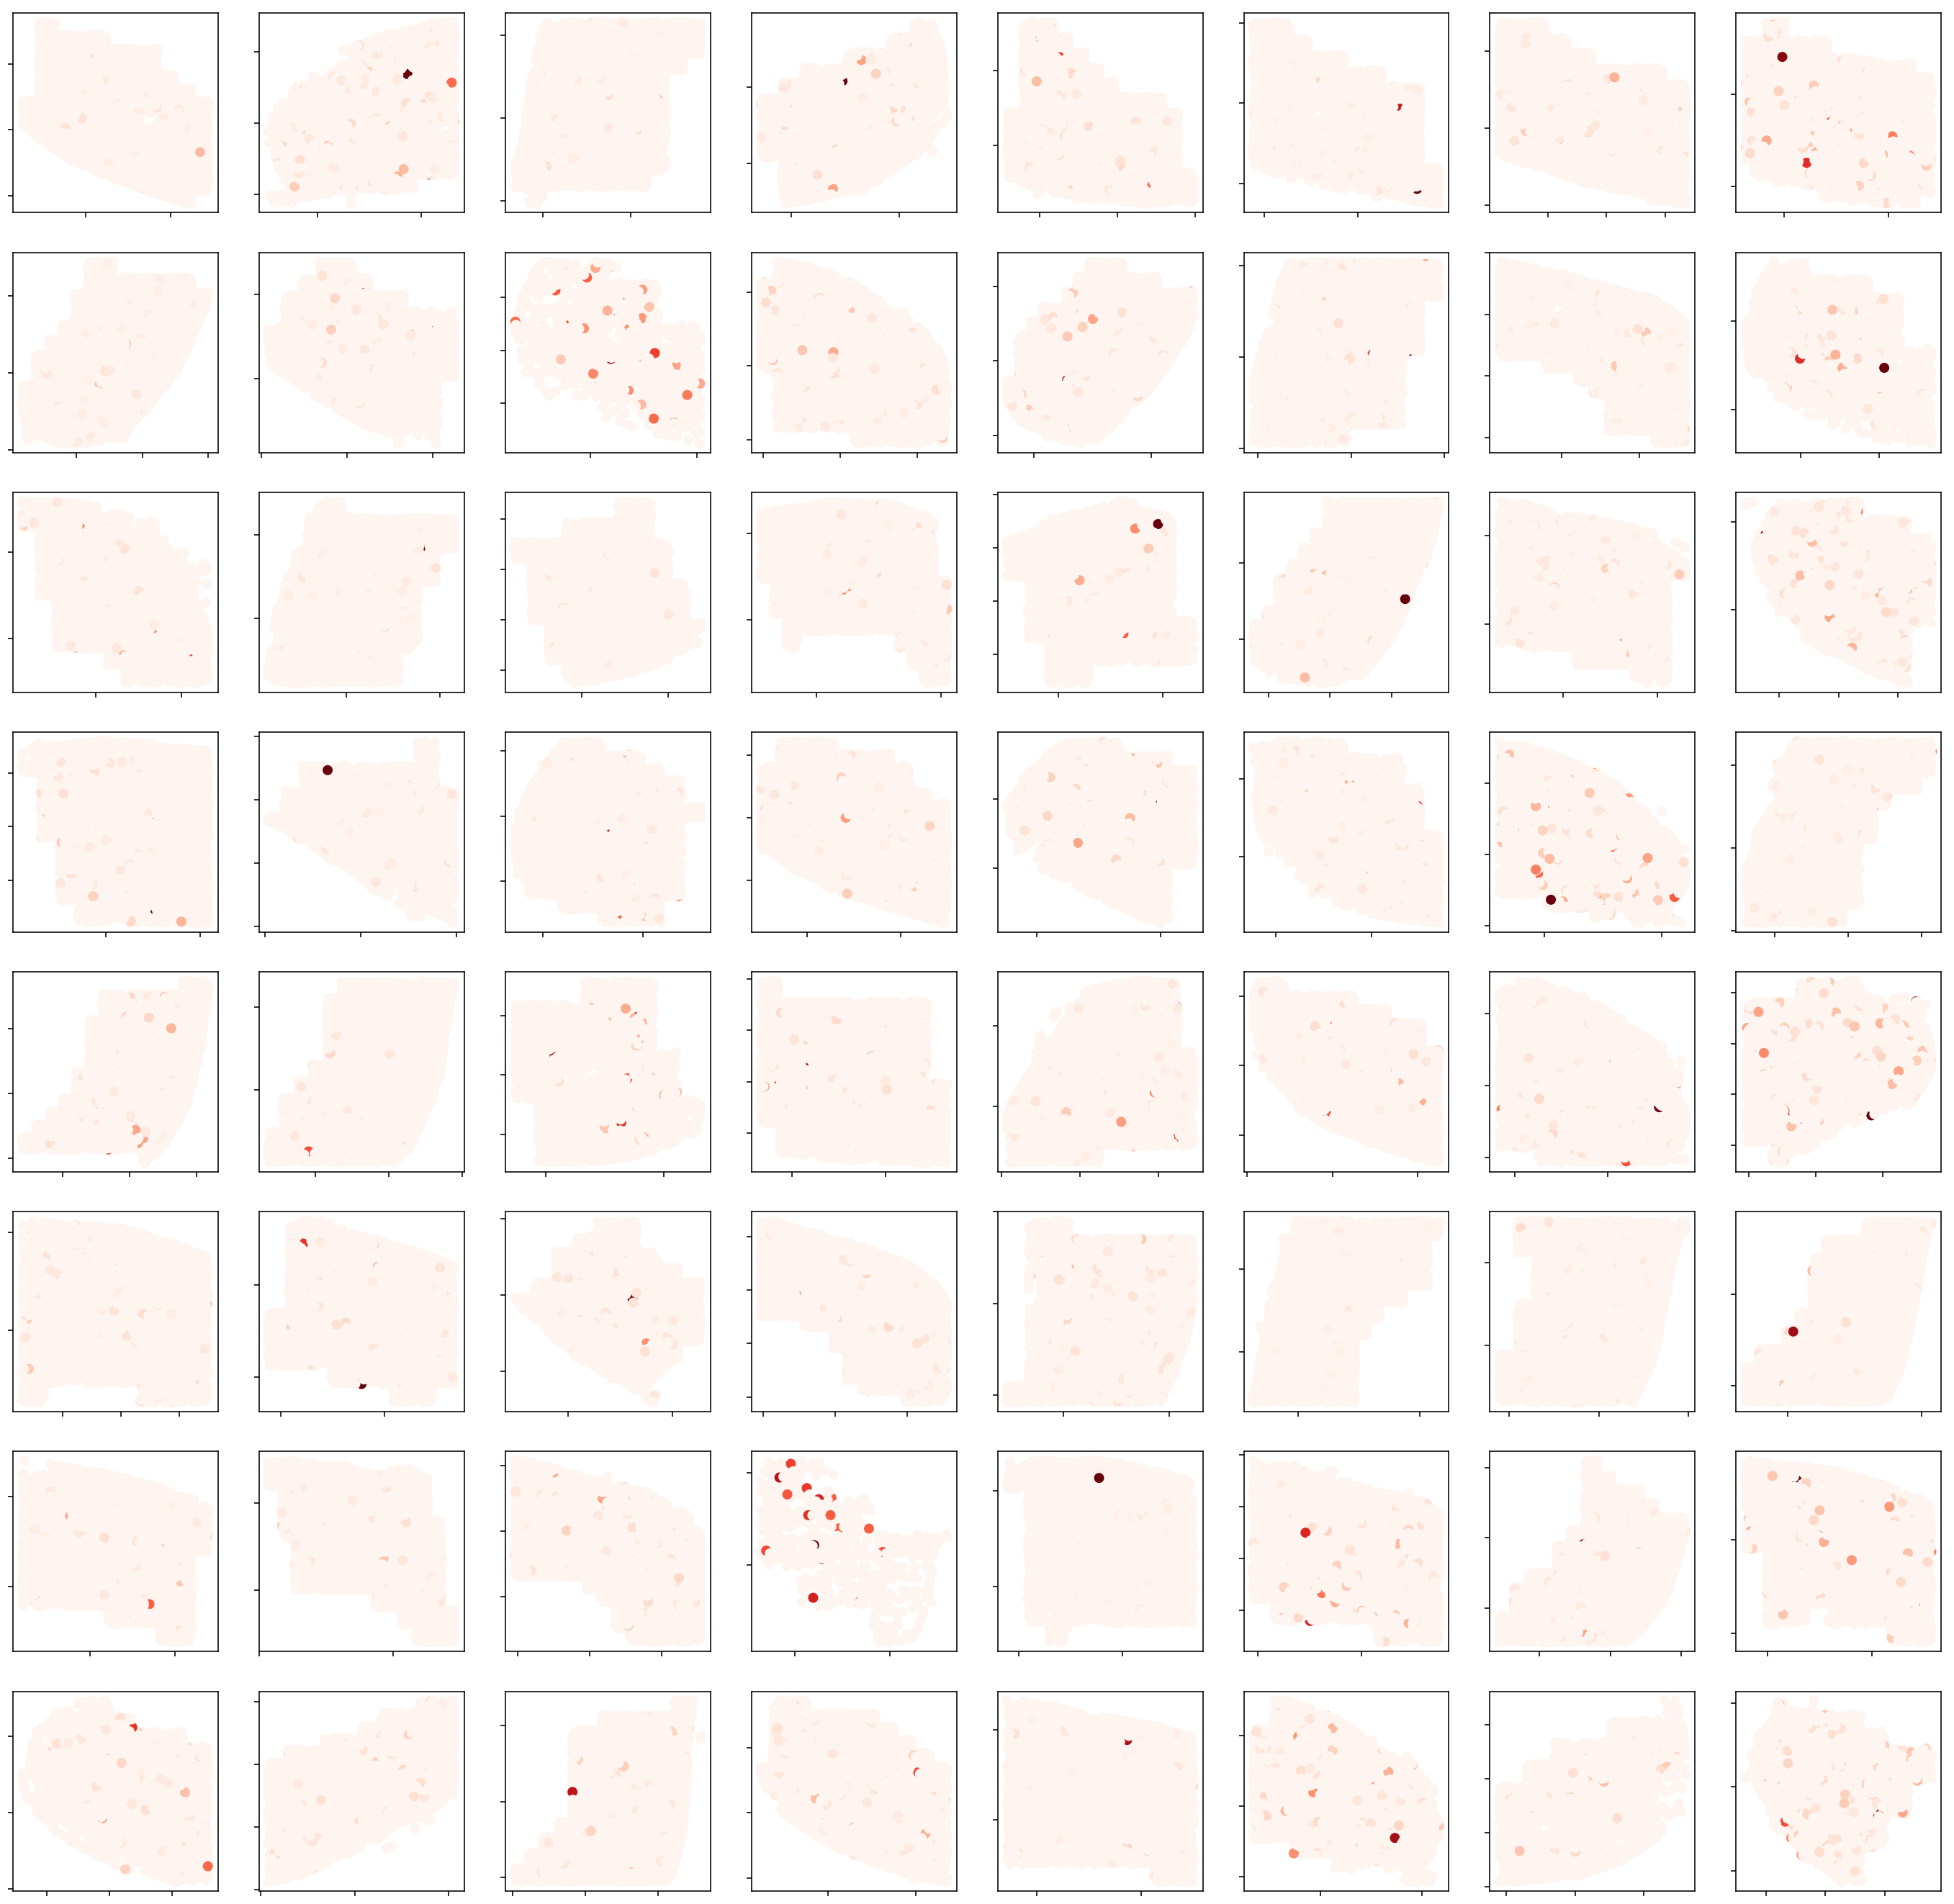

CPU times: user 33.1 s, sys: 12.7 s, total: 45.8 s
Wall time: 20.9 s


In [220]:
%%time
fig, ax = plt.subplots(figsize=(24,24), ncols=8, nrows=8)

axs = trim_axs(ax, len(sliceID))

gene_vec = adata.X[:,adata.var.index == gene]


for sidx, (ax, slice_name) in enumerate(zip(axs, sliceID)):
    s = gb.get_group(sliceID[sidx])
    
    X_mask = s.index.values
    
    x = adata.obs["pos_x (um)"][X_mask]
    y = adata.obs["pos_y (um)"][X_mask]
    c = np.asarray(gene_vec[X_mask]).reshape(-1)
    
    ax.scatter(x, y, c=c, cmap="Reds", label=slice_name)
    #ax.set_xlabel("X [µm]")
    #ax.set_ylabel("y [µm]")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
plt.show()

In [113]:
from sklearn.preprocessing import LabelEncoder

In [127]:
adata.obs.subclass.value_counts()

L2/3_IT             33757
L4/5_IT             29147
L6_CT               23878
Oligodendrocytes    19472
Astrocytes          19230
Endothelial         18183
L5_IT               14685
L6_IT               12475
Microglia            8554
Pvalb                7885
L5_PT                6759
Pericytes            6553
VLMC                 6173
Macrophages          5133
OPC                  4906
Sst                  4853
SMC                  3785
L6b                  3487
L56_NP               3482
striatum             3214
Lamp5                3095
Vip                  2789
L6_IT_Car3           1563
Sncg                  477
Sst_Chodl             232
Ependymal              32
Name: subclass, dtype: int64

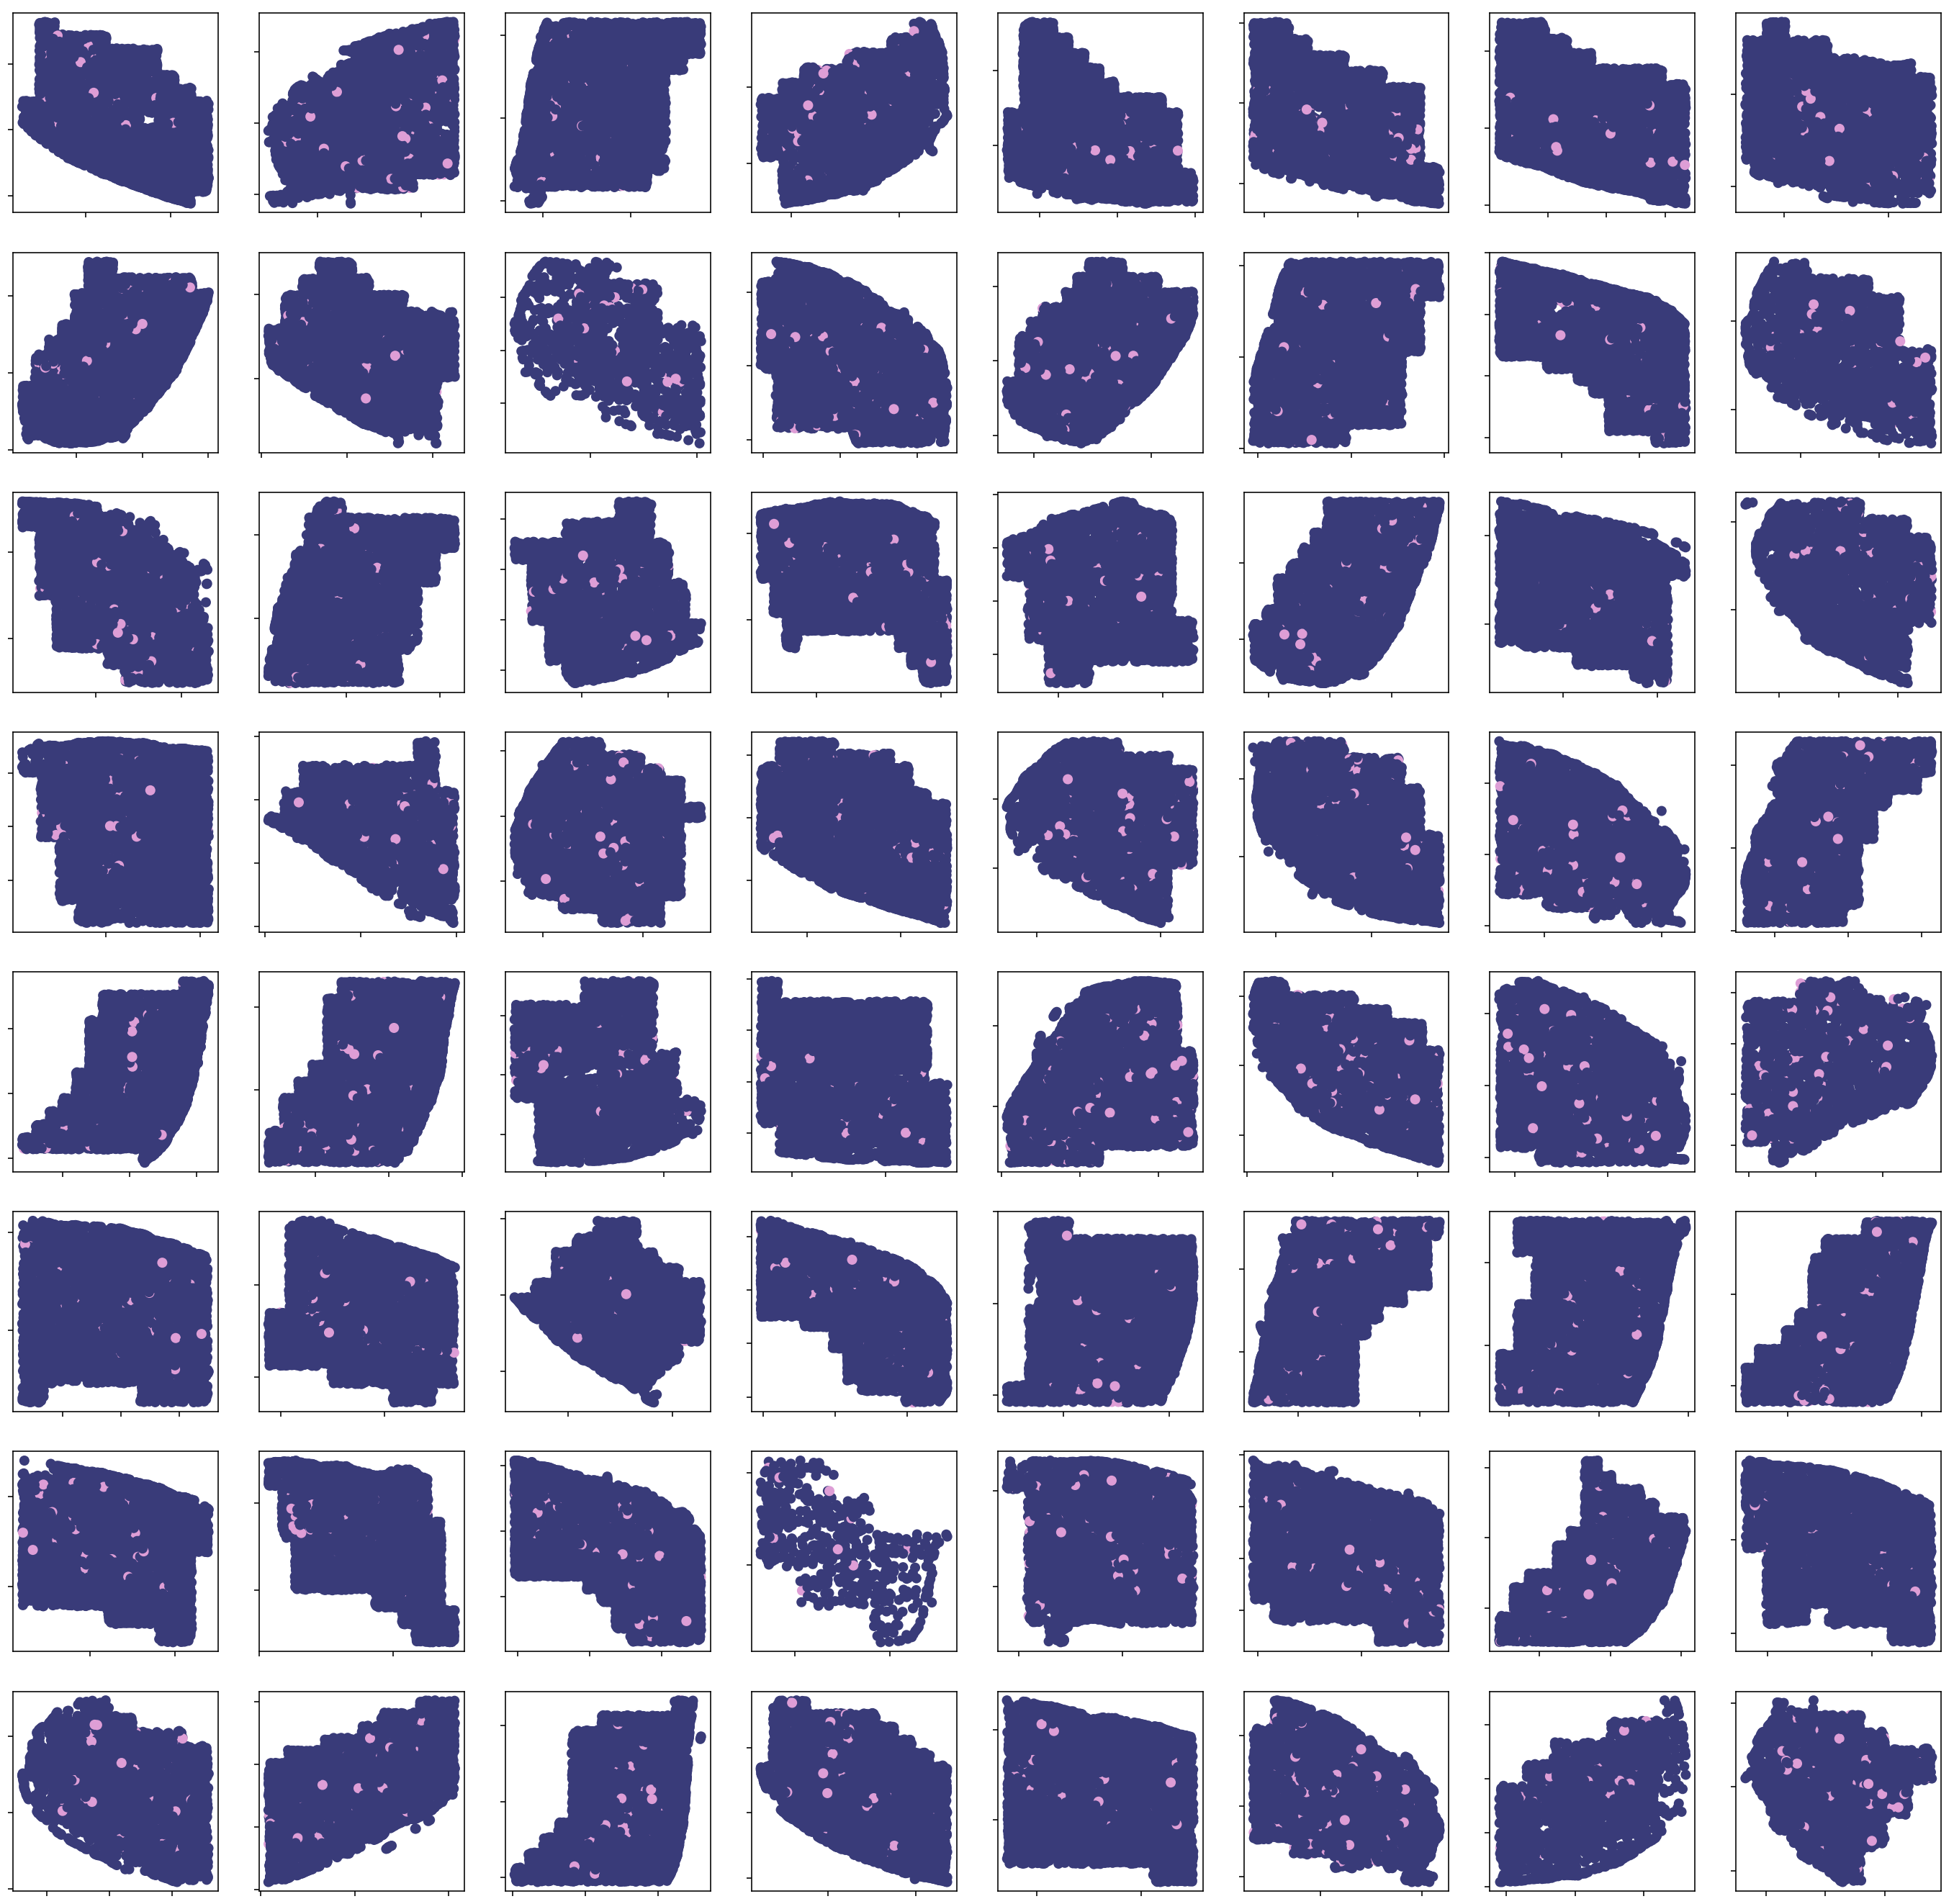

CPU times: user 33.2 s, sys: 12.6 s, total: 45.8 s
Wall time: 20.9 s


In [221]:
%%time
fig, ax = plt.subplots(figsize=(24,24), ncols=8, nrows=8)

axs = trim_axs(ax, len(sliceID))

#gene_vec = adata.X[:,adata.var.index == gene]
le = LabelEncoder()
subclass_vec = le.fit_transform(adata.obs.subclass.values=="Sst")

for sidx, (ax, slice_name) in enumerate(zip(axs, sliceID)):
    s = gb.get_group(sliceID[sidx])
    
    X_mask = s.index.values
    
    x = adata.obs["pos_x (um)"][X_mask]
    y = adata.obs["pos_y (um)"][X_mask]
    c = np.asarray(subclass_vec[X_mask]).reshape(-1)
    
    ax.scatter(x, y, c=c, cmap="tab20b", label=slice_name)
    #ax.set_xlabel("X [µm]")
    #ax.set_ylabel("y [µm]")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
plt.show()

In [188]:
mtx = adata.X

In [193]:
mat = np.log1p((mtx/mtx.sum(axis=1)[:,None])*1000000)

In [138]:
unique = adata.obs.subclass.unique()

In [139]:
unique

array(['Sst', 'Endothelial', 'L6_IT', 'L2/3_IT', 'VLMC', 'L6_CT',
       'L4/5_IT', 'Vip', 'Pvalb', 'Oligodendrocytes', 'Microglia',
       'L5_PT', 'L5_IT', 'Pericytes', 'Astrocytes', 'L56_NP',
       'L6_IT_Car3', 'OPC', 'Lamp5', 'SMC', 'Sncg', 'striatum', 'L6b',
       'Macrophages', 'Sst_Chodl', 'Ependymal'], dtype=object)

In [214]:
specific_gene = "Chodl"
c = "Sst"
x = mat[:,adata.var.index == specific_gene][adata.obs.subclass == c][:,0]
y = mat[:,adata.var.index == specific_gene][adata.obs.subclass != c][:,0]

In [215]:
cluster_exp = [x.mean(),y.mean()]

In [216]:
print(cluster_exp)

[0.3145910357717308, 0.3041326213194644]


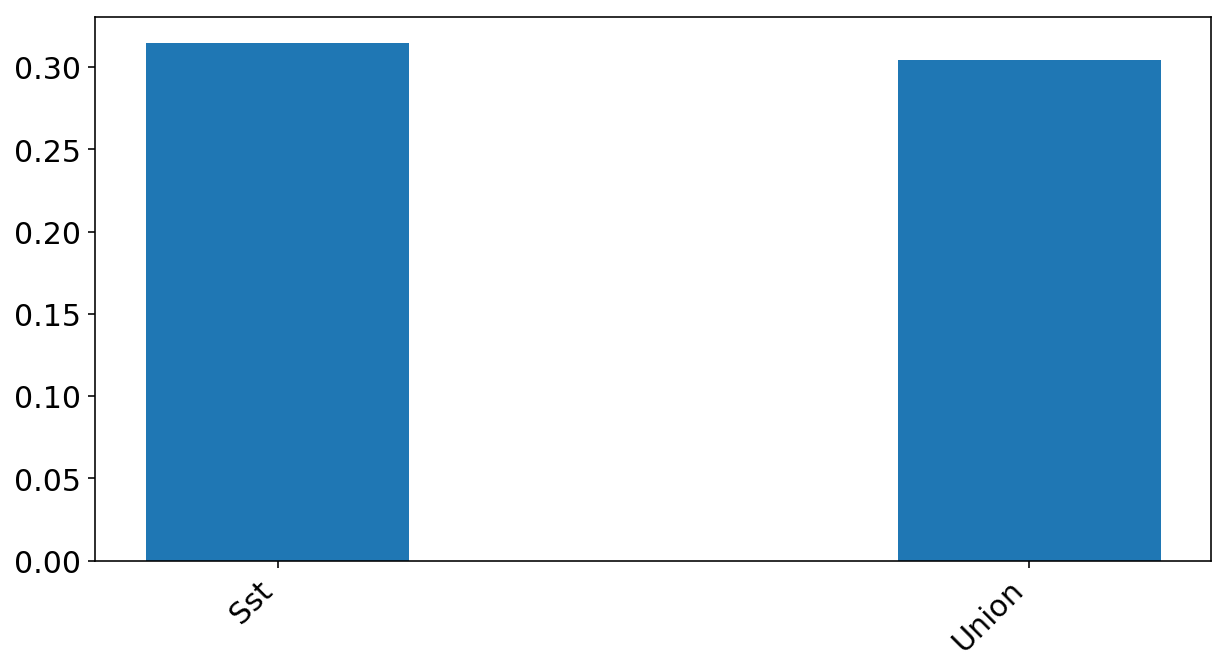

In [217]:
fig, ax = plt.subplots(figsize=(10,5))

labels = [c, "Union"]
lidx = np.arange(len(labels))  # the label locations

x = cluster_exp

width = 0.35  # the width of the bars

ax.bar(lidx, x, width)

ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
plt.show()

In [159]:
adata.obs.subclass==c

0         False
1         False
2         False
3         False
4         False
          ...  
243794    False
243795    False
243796    False
243797    False
243798    False
Name: subclass, Length: 243799, dtype: bool

In [154]:
adata[:,adata.var.index.values == specific_gene][adata.obs.subclass == c].X

ArrayView([[0.       ],
           [0.       ],
           [0.9453217],
           ...,
           [0.       ],
           [0.       ],
           [0.6022196]], dtype=float32)

In [148]:
adata

AnnData object with n_obs × n_vars = 243799 × 254 
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)'
    var: 'n_iso'